# Real Estate Listings Price Prediction

#### Senior Project 2020-21
#### Kelsey Dinndorf
#### Part 2 - Model

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.stats as stat
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [3]:
#insert data
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_5a7f0d32e3f74da881228669190705da = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='d9GnnkKQVvMXW5ZW8Gwh_62JvBA6cy47uvCw8KCnxxkh',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_5a7f0d32e3f74da881228669190705da.get_object(Bucket='seniorproject-donotdelete-pr-6dm4jsyzpqluep',Key='housing_crime_merged.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

hcdf = pd.read_csv(body)
hcdf.head()


,Uniq Id,Price,Sqr Ft,Beds,Bath,Year Built,Features,City,State,Days On Trulia,Lot Size(sqft),Price per Sqft,Population,Violent Crime Rate,Property Crime Rate
0,d6521bac40600f17287f0a5a8b3efc8d,895900.0,3447.0,4.0,4.5,2019.0,"Single Family Home | $260/sqft | Lot Size: 7,8...",Phoenix,AZ,110.0,7895.00000,259.91,1688722,0.006989,0.033146
1,c0b021f845c16f7ae098a5e105ac9217,300825.0,2537.0,3.0,4.0,2005.0,"Single Family Home | $119/sqft | Lot Size: 5,4...",Phoenix,AZ,126.0,5400.00000,118.58,1688722,0.006989,0.033146
2,b49804a33efa41bba44312df9d2ec280,1050000.0,2443.0,4.0,2.0,1962.0,Single Family Home | $430/sqft | Lot Size: 0.3...,Phoenix,AZ,3.0,14810.40000,429.80,1688722,0.006989,0.033146
3,32b631b5d0834e3bf8983b889f1eb285,490990.0,2005.0,2.0,2.5,1975.0,Single Family Home | $245/sqft | 180+ Days on ...,Phoenix,AZ,180.0,92933.22244,244.88,1688722,0.006989,0.033146
4,81d00428d77b64bf48e90472376403c5,190000.0,1732.0,4.0,2.0,1983.0,"Single Family Home | $110/sqft | Lot Size: 9,1...",Phoenix,AZ,29.0,9165.00000,109.70,1688722,0.006989,0.033146


### Get rid of Outliers (Z-score)

In [4]:
#create new column as an index for merging later
hcdf['new_col'] = range(1, len(hcdf) + 1)
print(hcdf)

                                Uniq Id      Price        Sqr Ft  Beds  Bath  \
0      d6521bac40600f17287f0a5a8b3efc8d   895900.0   3447.000000   4.0  4.50   
1      c0b021f845c16f7ae098a5e105ac9217   300825.0   2537.000000   3.0  4.00   
2      b49804a33efa41bba44312df9d2ec280  1050000.0   2443.000000   4.0  2.00   
3      32b631b5d0834e3bf8983b889f1eb285   490990.0   2005.000000   2.0  2.50   
4      81d00428d77b64bf48e90472376403c5   190000.0   1732.000000   4.0  2.00   
5      55ff0fa7116d26b0e04c642f9097b4c1   239999.0   2423.000000   4.0  2.00   
6      fb7ea2f708c39123adf16fb4dcce79d7   256000.0   2712.000000   5.0  4.00   
7      d28ef94ddd0b3d5e6798f3af6581dd9f   279900.0   1698.000000   4.0  2.00   
8      60d6c27df48b36af270ab1e3b5a800d0   160000.0   1260.000000   3.0  2.00   
9      8c330e4f4778115f43f465daddaaa8f8   267900.0   1311.000000   3.0  1.50   
10     6db15697fb7eff47edf366ff36fdbda2   460000.0   2431.000000   4.0  2.00   
11     9dfef3e5d70c188974da6932fefc2a56 

In [5]:
#get rid or change object data types
print("shape before :", hcdf.shape)
df_num = hcdf.select_dtypes(exclude=['object'])
print(df_num)

shape before : (22427, 16)
           Price        Sqr Ft  Beds  Bath  Year Built  Days On Trulia  \
0       895900.0   3447.000000   4.0  4.50      2019.0           110.0   
1       300825.0   2537.000000   3.0  4.00      2005.0           126.0   
2      1050000.0   2443.000000   4.0  2.00      1962.0             3.0   
3       490990.0   2005.000000   2.0  2.50      1975.0           180.0   
4       190000.0   1732.000000   4.0  2.00      1983.0            29.0   
5       239999.0   2423.000000   4.0  2.00      1969.0            65.0   
6       256000.0   2712.000000   5.0  4.00      2007.0           180.0   
7       279900.0   1698.000000   4.0  2.00      1979.0            15.0   
8       160000.0   1260.000000   3.0  2.00      1970.0            68.0   
9       267900.0   1311.000000   3.0  1.50      1948.0             3.0   
10      460000.0   2431.000000   4.0  2.00      2003.0             2.0   
11      184950.0    995.000000   2.0  2.00      1999.0           180.0   
12      425

In [6]:
from scipy import stats
#remove outliers with Zscore
#try different numbers - don't want to get rid of too many observations that could be valuable
df_Zscore = df_num[(np.abs(stats.zscore(df_num))<4).all(axis=1)]
print("shape after rejecting outliers: ", df_Zscore.shape)

shape after rejecting outliers:  (21912, 12)


Text(0.5, 1.0, 'After Z-score')

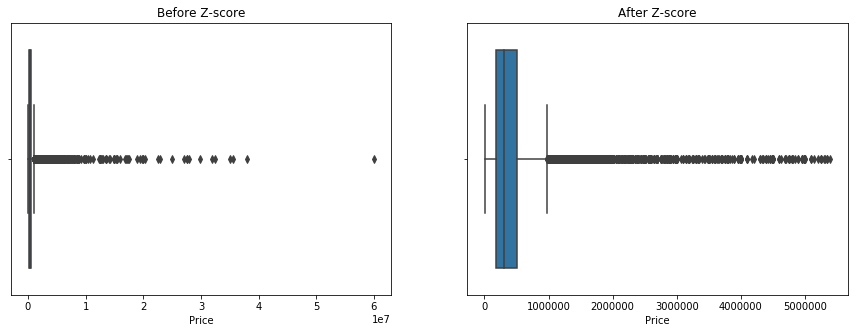

In [7]:
#boxplot of price
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sb.boxplot(x=hcdf['Price'])
plt.title('Before Z-score')

plt.subplot(1, 2, 2)
sb.boxplot(x=df_Zscore['Price'])
plt.title('After Z-score')

Text(0.5, 1.0, 'After Z-score')

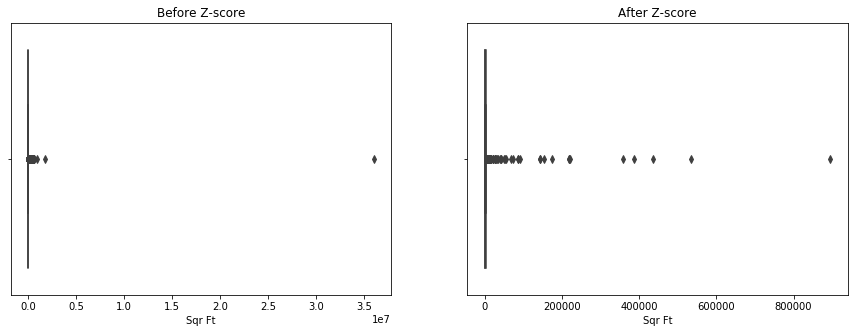

In [8]:
#boxplot of Sqr Ft

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sb.boxplot(x=hcdf['Sqr Ft'])
plt.title('Before Z-score')


plt.subplot(1, 2, 2)
sb.boxplot(x=df_Zscore['Sqr Ft'])
plt.title('After Z-score')

Text(0.5, 1.0, 'After Z-score')

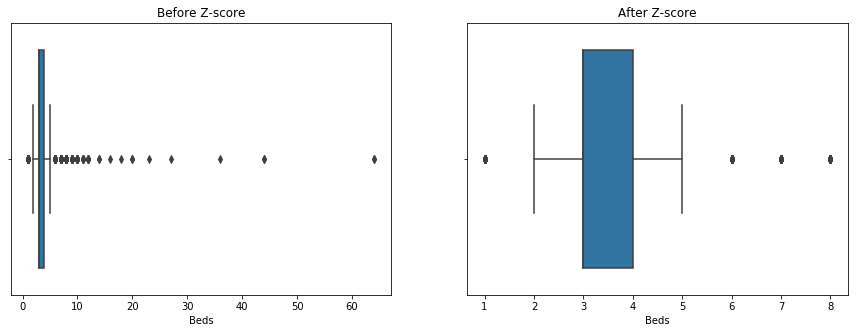

In [9]:
#boxplot of Beds

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sb.boxplot(x=hcdf['Beds'])
plt.title('Before Z-score')

plt.subplot(1, 2, 2)
sb.boxplot(x=df_Zscore['Beds'])
plt.title('After Z-score')

Text(0.5, 1.0, 'After Z-score')

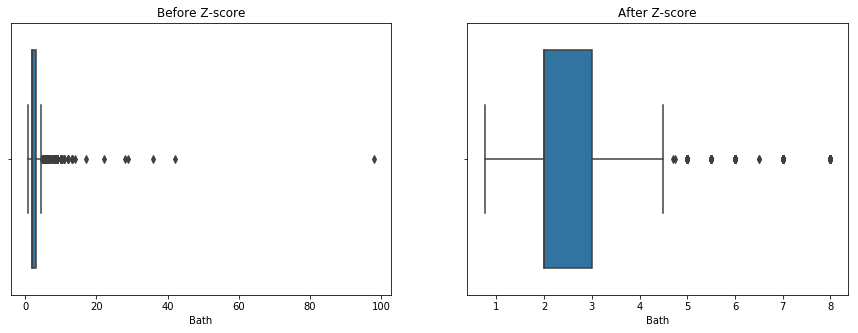

In [10]:
#boxplot of Bath

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sb.boxplot(x=hcdf['Bath'])
plt.title('Before Z-score')

plt.subplot(1, 2, 2)
sb.boxplot(x=df_Zscore['Bath'])
plt.title('After Z-score')

Text(0.5, 1.0, 'After Z-score')

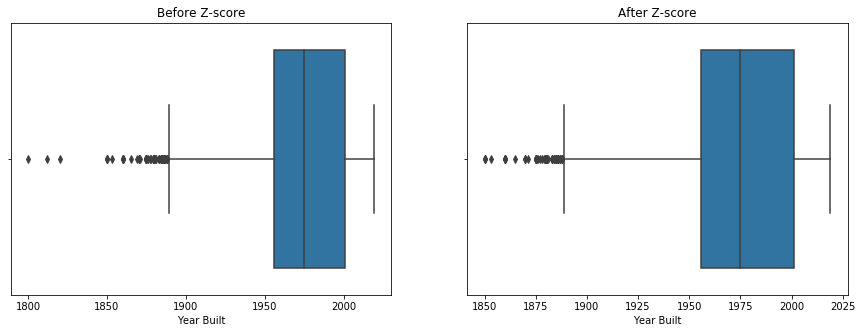

In [11]:
#boxplot of year built
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sb.boxplot(x=hcdf['Year Built'])
plt.title('Before Z-score')

plt.subplot(1, 2, 2)
sb.boxplot(x=df_Zscore['Year Built'])
plt.title('After Z-score')

Text(0.5, 1.0, 'After Z-score')

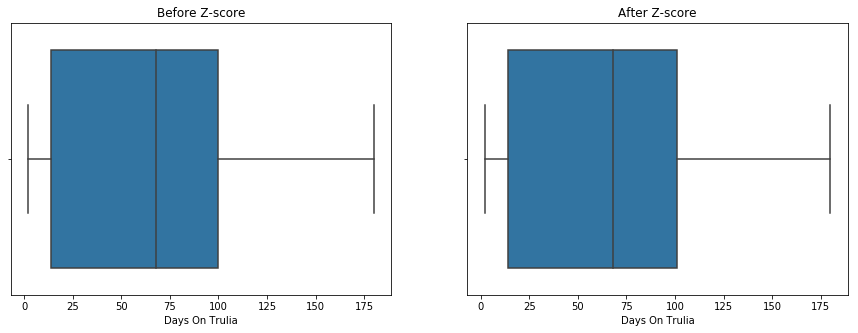

In [12]:
#boxplot of days on Trulia
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sb.boxplot(x=hcdf['Days On Trulia'])
plt.title('Before Z-score')

plt.subplot(1, 2, 2)
sb.boxplot(x=df_Zscore['Days On Trulia'])
plt.title('After Z-score')

Text(0.5, 1.0, 'After Z-score')

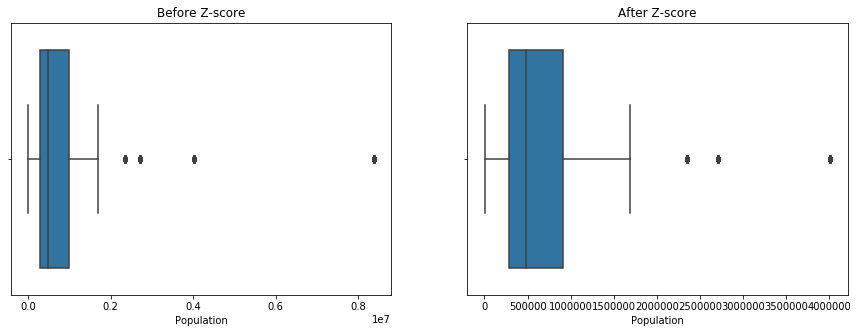

In [13]:
#boxplot of Population
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sb.boxplot(x=hcdf['Population'])
plt.title('Before Z-score')

plt.subplot(1, 2, 2)
sb.boxplot(x=df_Zscore['Population'])
plt.title('After Z-score')

Text(0.5, 1.0, 'After Z-score')

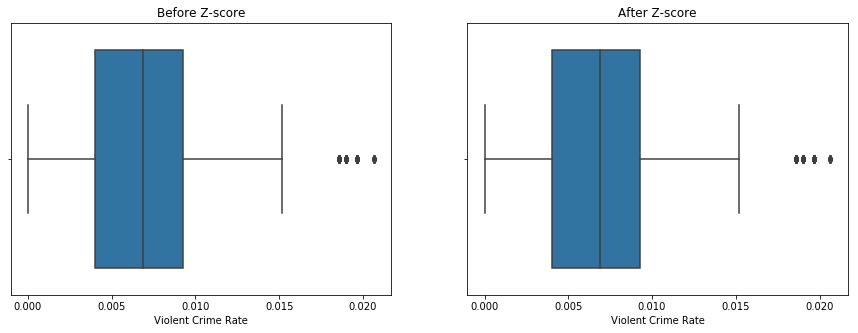

In [14]:
#boxplot of Violent Crime rate
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sb.boxplot(x=hcdf['Violent Crime Rate'])
plt.title('Before Z-score')

plt.subplot(1, 2, 2)
sb.boxplot(x=df_Zscore['Violent Crime Rate'])
plt.title('After Z-score')

Text(0.5, 1.0, 'After Z-score')

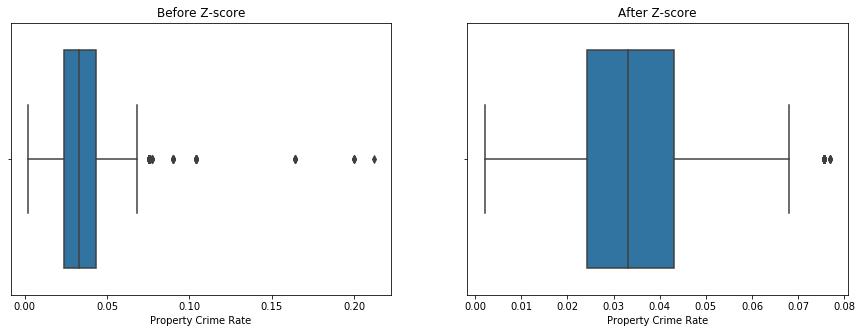

In [15]:
#boxplot of Property Crime Rate
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sb.boxplot(x=hcdf['Property Crime Rate'])
plt.title('Before Z-score')

plt.subplot(1, 2, 2)
sb.boxplot(x=df_Zscore['Property Crime Rate'])
plt.title('After Z-score')

Text(0.5, 1.0, 'After Z-score')

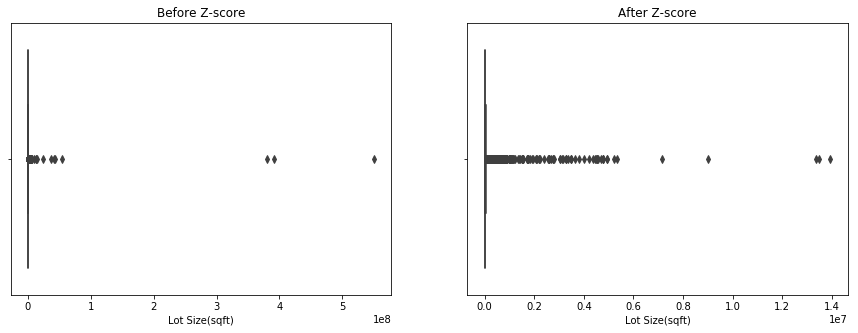

In [16]:
# Boxplot of Lot Size(sqft)
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sb.boxplot(x=hcdf['Lot Size(sqft)'])
plt.title('Before Z-score')

plt.subplot(1, 2, 2)
sb.boxplot(x=df_Zscore['Lot Size(sqft)'])
plt.title('After Z-score')

In [17]:
#merge the cleaned z-score data with original data
dfz = pd.merge(df_Zscore, hcdf, on="new_col")
print(dfz)

         Price_x      Sqr Ft_x  Beds_x  Bath_x  Year Built_x  \
0       895900.0   3447.000000     4.0    4.50        2019.0   
1       300825.0   2537.000000     3.0    4.00        2005.0   
2      1050000.0   2443.000000     4.0    2.00        1962.0   
3       490990.0   2005.000000     2.0    2.50        1975.0   
4       190000.0   1732.000000     4.0    2.00        1983.0   
5       239999.0   2423.000000     4.0    2.00        1969.0   
6       256000.0   2712.000000     5.0    4.00        2007.0   
7       279900.0   1698.000000     4.0    2.00        1979.0   
8       160000.0   1260.000000     3.0    2.00        1970.0   
9       267900.0   1311.000000     3.0    1.50        1948.0   
10      460000.0   2431.000000     4.0    2.00        2003.0   
11      184950.0    995.000000     2.0    2.00        1999.0   
12      425000.0   2986.000000     3.0    2.50        1999.0   
13      379000.0   2039.000000     3.0    3.00        1990.0   
14      995000.0   3040.000000     4.0  

In [18]:
#drop duplicate y columns
cols = ['new_col','Price_y','Sqr Ft_y','Beds_y','Bath_y','Year Built_y','Days On Trulia_y','Lot Size(sqft)_y',
       'Price per Sqft_y','Population_y','Violent Crime Rate_y','Property Crime Rate_y']
dfo = dfz.drop(cols, axis=1)
print(dfo.head())

     Price_x  Sqr Ft_x  Beds_x  Bath_x  Year Built_x  Days On Trulia_x  \
0   895900.0    3447.0     4.0     4.5        2019.0             110.0   
1   300825.0    2537.0     3.0     4.0        2005.0             126.0   
2  1050000.0    2443.0     4.0     2.0        1962.0               3.0   
3   490990.0    2005.0     2.0     2.5        1975.0             180.0   
4   190000.0    1732.0     4.0     2.0        1983.0              29.0   

   Lot Size(sqft)_x  Price per Sqft_x  Population_x  Violent Crime Rate_x  \
0        7895.00000            259.91       1688722              0.006989   
1        5400.00000            118.58       1688722              0.006989   
2       14810.40000            429.80       1688722              0.006989   
3       92933.22244            244.88       1688722              0.006989   
4        9165.00000            109.70       1688722              0.006989   

   Property Crime Rate_x                           Uniq Id  \
0               0.033146  d652

In [19]:
#rename columns
dfo.columns=['Price','Sqr Ft','Bedrooms','Bathrooms','Year Built','Days On Trulia','Lot Size(sqft)','Price per Sqft',
            'Population','Violent Crime Rate','Property Crime Rate','Uniq ID','Features', 'City','State']
dfo.head()

,Price,Sqr Ft,Bedrooms,Bathrooms,Year Built,Days On Trulia,Lot Size(sqft),Price per Sqft,Population,Violent Crime Rate,Property Crime Rate,Uniq ID,Features,City,State
0,895900.0,3447.0,4.0,4.5,2019.0,110.0,7895.00000,259.91,1688722,0.006989,0.033146,d6521bac40600f17287f0a5a8b3efc8d,"Single Family Home | $260/sqft | Lot Size: 7,8...",Phoenix,AZ
1,300825.0,2537.0,3.0,4.0,2005.0,126.0,5400.00000,118.58,1688722,0.006989,0.033146,c0b021f845c16f7ae098a5e105ac9217,"Single Family Home | $119/sqft | Lot Size: 5,4...",Phoenix,AZ
2,1050000.0,2443.0,4.0,2.0,1962.0,3.0,14810.40000,429.80,1688722,0.006989,0.033146,b49804a33efa41bba44312df9d2ec280,Single Family Home | $430/sqft | Lot Size: 0.3...,Phoenix,AZ
3,490990.0,2005.0,2.0,2.5,1975.0,180.0,92933.22244,244.88,1688722,0.006989,0.033146,32b631b5d0834e3bf8983b889f1eb285,Single Family Home | $245/sqft | 180+ Days on ...,Phoenix,AZ
4,190000.0,1732.0,4.0,2.0,1983.0,29.0,9165.00000,109.70,1688722,0.006989,0.033146,81d00428d77b64bf48e90472376403c5,"Single Family Home | $110/sqft | Lot Size: 9,1...",Phoenix,AZ


In [20]:
#drop Uniq ID and features columns for now
columns=['Uniq ID','Features']
dfm = dfo.drop(columns, axis=1)
dfm.head()

,Price,Sqr Ft,Bedrooms,Bathrooms,Year Built,Days On Trulia,Lot Size(sqft),Price per Sqft,Population,Violent Crime Rate,Property Crime Rate,City,State
0,895900.0,3447.0,4.0,4.5,2019.0,110.0,7895.00000,259.91,1688722,0.006989,0.033146,Phoenix,AZ
1,300825.0,2537.0,3.0,4.0,2005.0,126.0,5400.00000,118.58,1688722,0.006989,0.033146,Phoenix,AZ
2,1050000.0,2443.0,4.0,2.0,1962.0,3.0,14810.40000,429.80,1688722,0.006989,0.033146,Phoenix,AZ
3,490990.0,2005.0,2.0,2.5,1975.0,180.0,92933.22244,244.88,1688722,0.006989,0.033146,Phoenix,AZ
4,190000.0,1732.0,4.0,2.0,1983.0,29.0,9165.00000,109.70,1688722,0.006989,0.033146,Phoenix,AZ


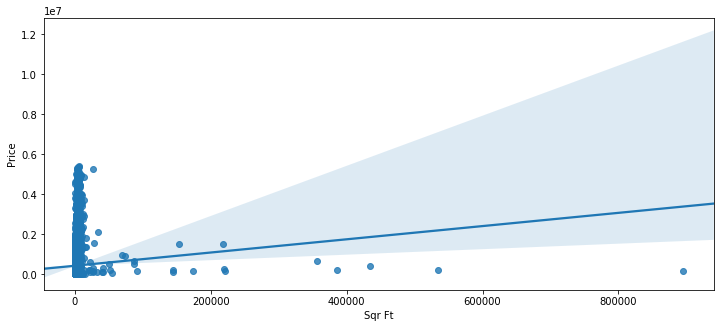

In [21]:
#regression plot for price vs sqr ft
plt.figure(figsize=(12,5))
sb.regplot(x="Sqr Ft", y="Price", data=dfm)

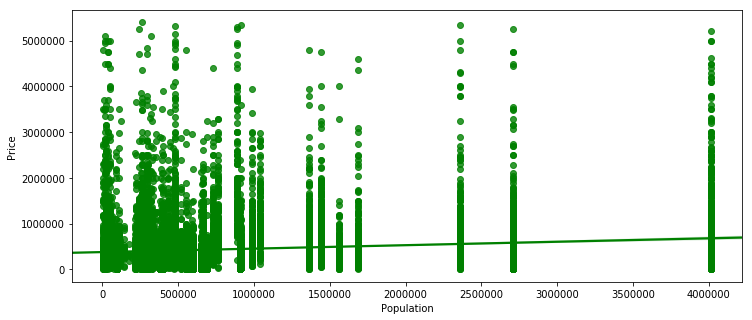

In [22]:
#regression plot for price vs population
plt.figure(figsize=(12,5))
sb.regplot(x="Population", y="Price", data=dfm, color='green')

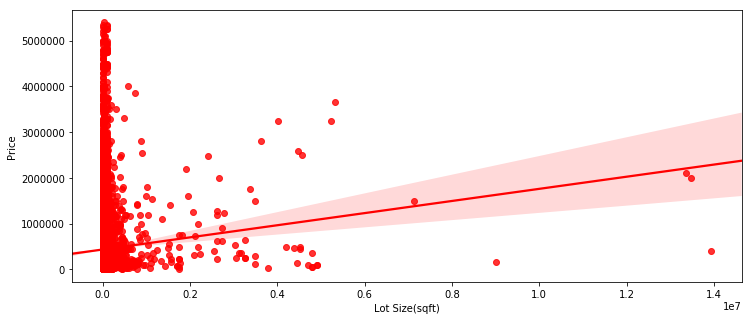

In [23]:
#regression plot for price vs lot size
plt.figure(figsize=(12,5))
sb.regplot(x="Lot Size(sqft)", y="Price", data=dfm, color='red')

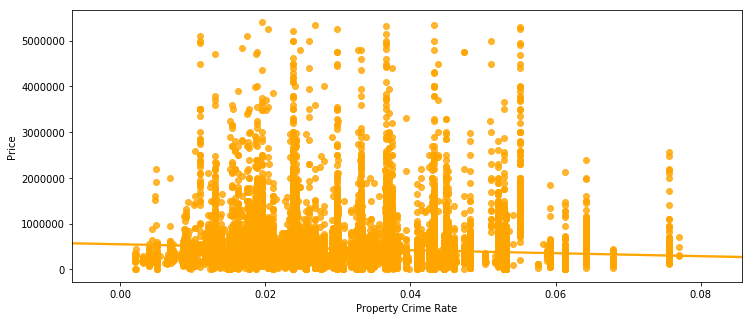

In [24]:
#regression plot for price vs property crime rate
plt.figure(figsize=(12,5))
sb.regplot(x="Property Crime Rate", y="Price", data=dfm, color='orange')

In [25]:
#Check column names
dfm.columns

Index(['Price', 'Sqr Ft', 'Bedrooms', 'Bathrooms', 'Year Built',
       'Days On Trulia', 'Lot Size(sqft)', 'Price per Sqft', 'Population',
       'Violent Crime Rate', 'Property Crime Rate', 'City', 'State'],
      dtype='object')

In [26]:
#define file to be exported (After normalizing the data using a Z-score)
Zscoredf = pd.DataFrame(dfm, columns= ['Price','Sqr Ft','Bedrooms','Bathrooms','Year Built','Days On Trulia','Lot Size(sqft)','Price per Sqft','Population','Violent Crime Rate','Property Crime Rate','City','State'])


In [27]:
# Export Zscoredf as a csv file to project assets

#@hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='e5b5564f-3061-4776-af66-2ba2d1874948', project_access_token='p-afce1f171120edb3c4d766e0d3b5a708f5fbf7d5')
pc = project.project_context

# save in your object storage as a csv file
project.save_data("Zscoredf.csv", Zscoredf.to_csv(index=False),overwrite = True)

{'file_name': 'Zscoredf.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'seniorproject-donotdelete-pr-6dm4jsyzpqluep',
 'asset_id': 'f3444f4c-9f23-4106-924d-d9e375fc4e89'}

In [28]:
# Group data by state and look at the mean values sorted by Price

Zscoredf.groupby('State').mean().sort_values(['Price'], ascending=False)

# CA has highest mean price 
# MI has lowest mean price

,Price,Sqr Ft,Bedrooms,Bathrooms,Year Built,Days On Trulia,Lot Size(sqft),Price per Sqft,Population,Violent Crime Rate,Property Crime Rate
State,,,,,,,,,,,
CA,936080.855728,2157.051794,3.166018,2.487707,1969.424537,62.319864,49447.487061,502.073267,1.370662e+06,0.005540,0.028841
WA,624963.270310,2148.152523,3.023715,2.192194,1970.401186,60.096838,35893.339815,358.623775,4.960955e+05,0.005529,0.045889
GA,585132.659091,2973.764060,3.598485,3.469697,1981.000000,84.803030,46218.680192,195.988258,7.503121e+04,0.003534,0.029837
OR,564553.687493,2473.828096,3.151589,2.391687,1968.775061,72.114914,47345.840954,275.822689,6.280080e+05,0.005260,0.050533
AZ,501096.005115,3083.687030,3.279083,2.483837,1985.293065,71.624161,38107.558602,189.718082,7.892448e+05,0.004768,0.026620
CO,492343.217596,2341.639630,3.215110,2.651889,1979.627492,61.357817,39205.147591,234.021857,5.301487e+05,0.006515,0.035005
FL,477472.962221,1988.145659,3.021530,2.443868,1983.723952,70.626682,41519.122055,248.098005,4.436149e+05,0.005537,0.034462
IL,466632.379272,2309.644115,3.167534,2.274298,1952.598335,59.668054,28369.288280,233.826087,2.704272e+06,0.009425,0.029807
NV,441227.519616,2615.993731,3.317254,2.684787,1994.367347,74.959184,92130.168819,182.741707,2.797318e+05,0.004695,0.019380


In [29]:
# Group data by year built and look at the mean values 

Zscoredf.groupby('Year Built').mean()

,Price,Sqr Ft,Bedrooms,Bathrooms,Days On Trulia,Lot Size(sqft),Price per Sqft,Population,Violent Crime Rate,Property Crime Rate
Year Built,,,,,,,,,,
1850.0,3.214667e+05,1449.333333,2.333333,2.000000,57.000000,32224.407480,215.366667,4.992710e+05,0.015207,0.043083
1853.0,2.574000e+06,3960.000000,5.000000,4.000000,99.000000,3852.000000,650.000000,3.944980e+05,0.011447,0.052925
1860.0,2.749800e+05,1862.600000,3.000000,2.600000,123.400000,107261.640000,150.302000,4.373956e+05,0.014201,0.035248
1865.0,9.950000e+05,3900.000000,4.000000,4.000000,180.000000,74052.000000,255.130000,3.033350e+05,0.008446,0.043025
1870.0,1.149950e+06,3150.000000,3.500000,3.500000,99.000000,1561.500000,285.385000,4.958685e+05,0.015017,0.048019
1871.0,1.300000e+06,5082.979414,5.000000,2.000000,68.000000,1306.000000,255.760000,2.814220e+05,0.006190,0.016410
1875.0,1.733000e+05,1461.545455,2.636364,2.090909,42.636364,2713.909091,143.522727,7.130513e+05,0.013579,0.040149
1876.0,6.290000e+05,1428.000000,2.000000,3.000000,15.000000,3081.000000,440.480000,2.707064e+06,0.009432,0.029826
1877.0,3.200000e+04,5082.979414,4.000000,2.000000,2.000000,2613.000000,6.300000,2.707064e+06,0.009432,0.029826


### 1-hot and Feature Scale

In [30]:
## 1-hot categorical variables: City, State  (create dummy variables)
## Feature Scale everything else

In [31]:
#check data types
dfm.dtypes

Price                  float64
Sqr Ft                 float64
Bedrooms               float64
Bathrooms              float64
Year Built             float64
Days On Trulia         float64
Lot Size(sqft)         float64
Price per Sqft         float64
Population               int64
Violent Crime Rate     float64
Property Crime Rate    float64
City                    object
State                   object
dtype: object

In [32]:
#Categorical to numbers for City (1-hot)
City_dummy = pd.get_dummies(dfm["City"], prefix='City', drop_first=True, columns=['City'])    #create k-1 dummy variables for k categories
City_dummy.head()

,City_Albuquerque,City_Anaheim,City_Anchorage,City_Apple Valley,City_Arlington,City_Atlantic Beach,City_Aurora,City_Austin,City_Aventura,City_Bainbridge Island,...,City_White Settlement,City_Whitefish Bay,City_Whitehall,City_Wichita,City_Windsor Heights,City_Winter Park,City_Wolfforth,City_Woodbury,City_Worthington,City_Yukon
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
#Merge data from dfm and City_dummy
dfcd = pd.concat([dfm, City_dummy], axis=1)
#drop original column "City" from "dfcd"
dfcd.drop("City", axis = 1, inplace=True)
dfcd.head()

,Price,Sqr Ft,Bedrooms,Bathrooms,Year Built,Days On Trulia,Lot Size(sqft),Price per Sqft,Population,Violent Crime Rate,...,City_White Settlement,City_Whitefish Bay,City_Whitehall,City_Wichita,City_Windsor Heights,City_Winter Park,City_Wolfforth,City_Woodbury,City_Worthington,City_Yukon
0,895900.0,3447.0,4.0,4.5,2019.0,110.0,7895.00000,259.91,1688722,0.006989,...,0,0,0,0,0,0,0,0,0,0
1,300825.0,2537.0,3.0,4.0,2005.0,126.0,5400.00000,118.58,1688722,0.006989,...,0,0,0,0,0,0,0,0,0,0
2,1050000.0,2443.0,4.0,2.0,1962.0,3.0,14810.40000,429.80,1688722,0.006989,...,0,0,0,0,0,0,0,0,0,0
3,490990.0,2005.0,2.0,2.5,1975.0,180.0,92933.22244,244.88,1688722,0.006989,...,0,0,0,0,0,0,0,0,0,0
4,190000.0,1732.0,4.0,2.0,1983.0,29.0,9165.00000,109.70,1688722,0.006989,...,0,0,0,0,0,0,0,0,0,0


In [34]:
#Categorical to numbers for State (1-hot)
State_dummy = pd.get_dummies(dfcd["State"], prefix='State', drop_first=True, columns=['State'])    #create k-1 dummy variables for k categories
State_dummy.head()

,State_AL,State_AZ,State_CA,State_CO,State_FL,State_GA,State_IA,State_ID,State_IL,State_IN,...,State_NY,State_OH,State_OK,State_OR,State_PA,State_TN,State_TX,State_VA,State_WA,State_WI
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
#Merge data from dfcd and State_dummy
dfsd = pd.concat([dfcd, State_dummy], axis=1)
#drop original column "State" from "dfsd"
dfsd.drop("State", axis = 1, inplace=True)
dfsd.head()

,Price,Sqr Ft,Bedrooms,Bathrooms,Year Built,Days On Trulia,Lot Size(sqft),Price per Sqft,Population,Violent Crime Rate,...,State_NY,State_OH,State_OK,State_OR,State_PA,State_TN,State_TX,State_VA,State_WA,State_WI
0,895900.0,3447.0,4.0,4.5,2019.0,110.0,7895.00000,259.91,1688722,0.006989,...,0,0,0,0,0,0,0,0,0,0
1,300825.0,2537.0,3.0,4.0,2005.0,126.0,5400.00000,118.58,1688722,0.006989,...,0,0,0,0,0,0,0,0,0,0
2,1050000.0,2443.0,4.0,2.0,1962.0,3.0,14810.40000,429.80,1688722,0.006989,...,0,0,0,0,0,0,0,0,0,0
3,490990.0,2005.0,2.0,2.5,1975.0,180.0,92933.22244,244.88,1688722,0.006989,...,0,0,0,0,0,0,0,0,0,0
4,190000.0,1732.0,4.0,2.0,1983.0,29.0,9165.00000,109.70,1688722,0.006989,...,0,0,0,0,0,0,0,0,0,0


In [36]:
dfsd.dtypes

Price                      float64
Sqr Ft                     float64
Bedrooms                   float64
Bathrooms                  float64
Year Built                 float64
Days On Trulia             float64
Lot Size(sqft)             float64
Price per Sqft             float64
Population                   int64
Violent Crime Rate         float64
Property Crime Rate        float64
City_Albuquerque             uint8
City_Anaheim                 uint8
City_Anchorage               uint8
City_Apple Valley            uint8
City_Arlington               uint8
City_Atlantic Beach          uint8
City_Aurora                  uint8
City_Austin                  uint8
City_Aventura                uint8
City_Bainbridge Island       uint8
City_Baker                   uint8
City_Bakersfield             uint8
City_Baltimore               uint8
City_Baton Rouge             uint8
City_Bay Harbor Islands      uint8
City_Bay Village             uint8
City_Bayside                 uint8
City_Beachwood      

In [37]:
#feature scale all numerical data using min and max
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

dfnum = dfsd.select_dtypes(exclude=['object'])

columnnames= list(dfsd.columns)     #save column names as a list

#Use MinMax scaler to normalize the data and feature scale between 0 and 1
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
scaled_df = scaler.fit_transform(dfnum)
scaled_df = pd.DataFrame(scaled_df, columns=columnnames)
print(scaled_df)

          Price    Sqr Ft  Bedrooms  Bathrooms  Year Built  Days On Trulia  \
0      0.165792  0.003848  0.428571   0.517241    1.000000        0.606742   
1      0.055577  0.002832  0.285714   0.448276    0.917160        0.696629   
2      0.194333  0.002727  0.428571   0.172414    0.662722        0.005618   
3      0.090798  0.002238  0.142857   0.241379    0.739645        1.000000   
4      0.035051  0.001933  0.428571   0.172414    0.786982        0.151685   
5      0.044312  0.002705  0.428571   0.172414    0.704142        0.353933   
6      0.047275  0.003028  0.571429   0.448276    0.928994        1.000000   
7      0.051702  0.001895  0.428571   0.172414    0.763314        0.073034   
8      0.029495  0.001406  0.285714   0.172414    0.710059        0.370787   
9      0.049479  0.001463  0.285714   0.103448    0.579882        0.005618   
10     0.085058  0.002714  0.428571   0.172414    0.905325        0.000000   
11     0.034116  0.001110  0.142857   0.172414    0.881657      

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


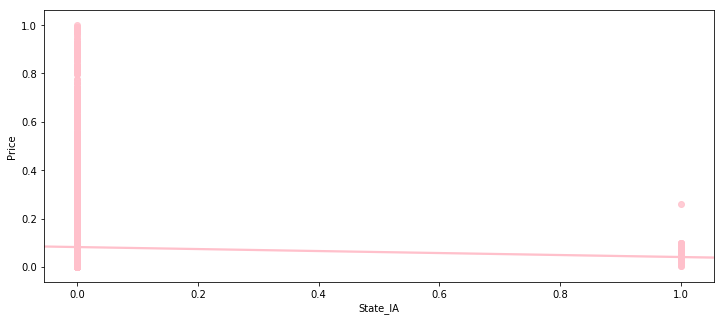

In [38]:
#regression plot for price vs State_IA
plt.figure(figsize=(12,5))
sb.regplot(x="State_IA", y="Price", data=scaled_df, color='pink')

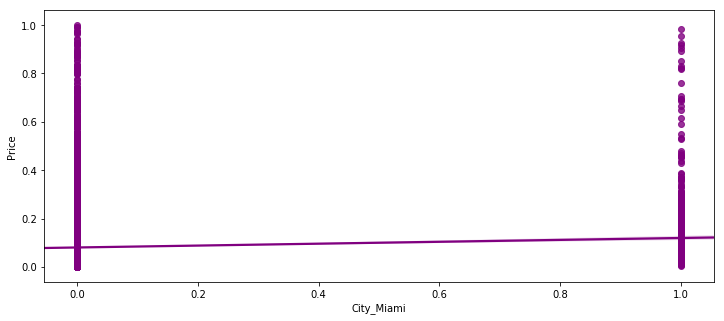

In [39]:
#regression plot for price vs City_Miami
plt.figure(figsize=(12,5))
sb.regplot(x="City_Miami", y="Price", data=scaled_df, color='purple')

In [40]:
# Check column names and shape of dataset
print(scaled_df.columns)
print(scaled_df.shape)

Index(['Price', 'Sqr Ft', 'Bedrooms', 'Bathrooms', 'Year Built',
       'Days On Trulia', 'Lot Size(sqft)', 'Price per Sqft', 'Population',
       'Violent Crime Rate',
       ...
       'State_NY', 'State_OH', 'State_OK', 'State_OR', 'State_PA', 'State_TN',
       'State_TX', 'State_VA', 'State_WA', 'State_WI'],
      dtype='object', length=381)
(21912, 381)


In [41]:
#define file to be exported (After scaling the data using feature scaling and 1-hotting)
Scaleddf = pd.DataFrame(scaled_df)

In [42]:
# Export Scaleddf as a csv file to project assets

#@hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='e5b5564f-3061-4776-af66-2ba2d1874948', project_access_token='p-afce1f171120edb3c4d766e0d3b5a708f5fbf7d5')
pc = project.project_context

# save in your object storage as a csv file
project.save_data("Scaleddf.csv", Scaleddf.to_csv(index=False),overwrite = True)

{'file_name': 'Scaleddf.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'seniorproject-donotdelete-pr-6dm4jsyzpqluep',
 'asset_id': 'd0fa0921-125a-45d1-9138-34d535d7d516'}

In [43]:
Scaleddf.head()

,Price,Sqr Ft,Bedrooms,Bathrooms,Year Built,Days On Trulia,Lot Size(sqft),Price per Sqft,Population,Violent Crime Rate,...,State_NY,State_OH,State_OK,State_OR,State_PA,State_TN,State_TX,State_VA,State_WA,State_WI
0,0.165792,0.003848,0.428571,0.517241,1.000000,0.606742,0.000566,0.013686,0.420407,0.338491,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.055577,0.002832,0.285714,0.448276,0.917160,0.696629,0.000387,0.006240,0.420407,0.338491,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.194333,0.002727,0.428571,0.172414,0.662722,0.005618,0.001062,0.022637,0.420407,0.338491,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.090798,0.002238,0.142857,0.241379,0.739645,1.000000,0.006667,0.012894,0.420407,0.338491,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.035051,0.001933,0.428571,0.172414,0.786982,0.151685,0.000657,0.005772,0.420407,0.338491,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Regression Models

In [44]:
#Split data into training set(80%) and test set(20%) 
#Creating training and testing set by choosing random observations
rand = np.random.rand(len(scaled_df)) < 0.8
train = scaled_df[rand]
test = scaled_df[~rand]

Coefficients:  [[0.44421749]]
Intercept:  [0.08011109]
Mean absolute error: 0.06
Residual sum of squares (MSE): 0.01
R2-score: 0.0051


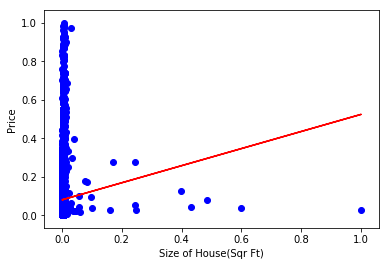

In [45]:
#Simple Linear regression for Price vs Size of House (Sqr Ft)
#Modeling
from sklearn import linear_model

regr = linear_model.LinearRegression()
train_x = train[['Sqr Ft']]
train_y = train[['Price']]
regr.fit (train_x, train_y)

# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ', regr.intercept_)

#Fit line over data
plt.scatter(train_x, train_y,  color='blue')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.xlabel("Size of House(Sqr Ft)")
plt.ylabel("Price")

#Evaluation
#we compare the actual values and predicted values to calculate the accuracy of a regression model.
#There are different model evaluation metrics, lets use MSE here to calculate the accuracy of our model based on the test set:
#- Mean absolute error: It is the mean of the absolute value of the errors. This is the easiest of the metrics to understand since it’s just average error.
#- Mean Squared Error (MSE): Mean Squared Error (MSE) is the mean of the squared error. It’s more popular than Mean absolute error
#- R-squared is not error, but is a popular metric for accuracy of your model -higher R-squared is better
from sklearn.metrics import r2_score

test_x = np.asanyarray(test[['Sqr Ft']])
test_y = np.asanyarray(test[['Price']])
test_y_ = regr.predict(test_x)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.4f" % r2_score(test_y , test_y_) )

#not a good r-squared value

Coefficients:  [[-0.07548958]]
Intercept:  [0.10689581]
Mean absolute error: 0.06
Residual sum of squares (MSE): 0.01
R2-score: 0.0241


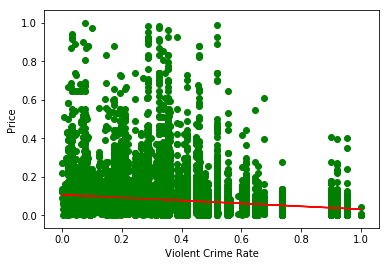

In [46]:
#Simple Linear regression for Price vs Violent Crime Rate

regr = linear_model.LinearRegression()
train_x = train[['Violent Crime Rate']]
train_y = train[['Price']]
regr.fit (train_x, train_y)

# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ', regr.intercept_)

#Fit line over data
plt.scatter(train_x, train_y,  color='green')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.xlabel("Violent Crime Rate")
plt.ylabel("Price")

#Evaluation
test_x = np.asanyarray(test[['Violent Crime Rate']])
test_y = np.asanyarray(test[['Price']])
test_y_ = regr.predict(test_x)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.4f" % r2_score(test_y , test_y_) )

#not a good r-squared value

Coefficients:  [[-0.03833625]]
Intercept:  [0.08192781]
Mean absolute error: 0.06
Residual sum of squares (MSE): 0.01
R2-score: 0.0013


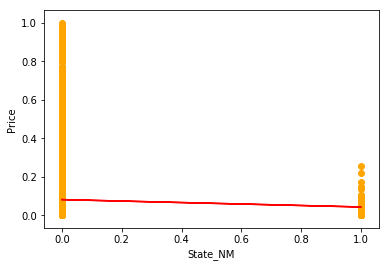

In [47]:
#Simple Linear regression for Price vs State_NM (New Mexico)

regr = linear_model.LinearRegression()
train_x = train[['State_NM']]
train_y = train[['Price']]
regr.fit (train_x, train_y)

# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ', regr.intercept_)

#Fit line over data
plt.scatter(train_x, train_y,  color='orange')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.xlabel("State_NM")
plt.ylabel("Price")

#Evaluation
test_x = np.asanyarray(test[['State_NM']])
test_y = np.asanyarray(test[['Price']])
test_y_ = regr.predict(test_x)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.4f" % r2_score(test_y , test_y_) )

#not a good r-squared value

Coefficients:  [[0.03964732]]
Intercept:  [0.05206008]
Mean absolute error: 0.06
Residual sum of squares (MSE): 0.01
R2-score: 0.0054


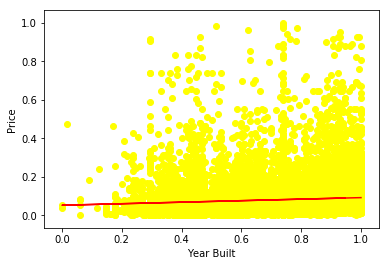

In [48]:
#Simple Linear regression for Price vs Year Built

regr = linear_model.LinearRegression()
train_x = train[['Year Built']]
train_y = train[['Price']]
regr.fit (train_x, train_y)

# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ', regr.intercept_)

#Fit line over data
plt.scatter(train_x, train_y,  color='yellow')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.xlabel("Year Built")
plt.ylabel("Price")

#Evaluation
test_x = np.asanyarray(test[['Year Built']])
test_y = np.asanyarray(test[['Price']])
test_y_ = regr.predict(test_x)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.4f" % r2_score(test_y , test_y_) )

#not a good r-squared value

Coefficients:  [[0.15314652]]
Intercept:  [0.03264478]
Mean absolute error: 0.05
Residual sum of squares (MSE): 0.01
R2-score: 0.0778


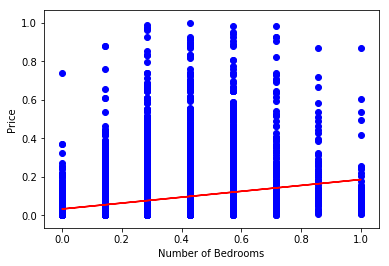

In [49]:
#Simple Linear regression for Price vs number of Bedrooms

regr = linear_model.LinearRegression()
train_x = train[['Bedrooms']]
train_y = train[['Price']]
regr.fit (train_x, train_y)

# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ', regr.intercept_)

#Fit line over data
plt.scatter(train_x, train_y,  color='blue')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.xlabel("Number of Bedrooms")
plt.ylabel("Price")

#Evaluation
test_x = np.asanyarray(test[['Bedrooms']])
test_y = np.asanyarray(test[['Price']])
test_y_ = regr.predict(test_x)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.4f" % r2_score(test_y , test_y_) )

#r-squared value is better

Coefficients:  [[0.32598227]]
Intercept:  [0.00370632]
Mean absolute error: 0.05
Residual sum of squares (MSE): 0.01
R2-score: 0.2910


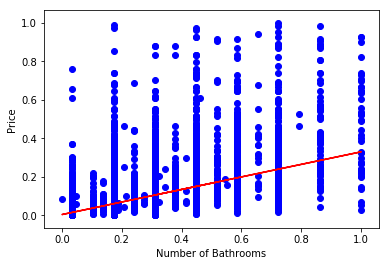

In [50]:
#Simple Linear regression for Price vs number of Bathrooms

regr = linear_model.LinearRegression()
train_x = train[['Bathrooms']]
train_y = train[['Price']]
regr.fit (train_x, train_y)

# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ', regr.intercept_)

#Fit line over data
plt.scatter(train_x, train_y,  color='blue')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.xlabel("Number of Bathrooms")
plt.ylabel("Price")

#Evaluation
test_x = np.asanyarray(test[['Bathrooms']])
test_y = np.asanyarray(test[['Price']])
test_y_ = regr.predict(test_x)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.4f" % r2_score(test_y , test_y_) )

#r-squared value is higher

In [51]:
#Correlation
print("Correlation:")
print(scaled_df.corr())

Correlation:
                            Price    Sqr Ft  Bedrooms  Bathrooms  Year Built  \
Price                    1.000000  0.059246  0.250388   0.518869    0.076384   
Sqr Ft                   0.059246  1.000000  0.064955   0.072567    0.022727   
Bedrooms                 0.250388  0.064955  1.000000   0.593250    0.000930   
Bathrooms                0.518869  0.072567  0.593250   1.000000    0.285519   
Year Built               0.076384  0.022727  0.000930   0.285519    1.000000   
Days On Trulia           0.076545  0.047135  0.049597   0.107066    0.060716   
Lot Size(sqft)           0.065291  0.031466 -0.042715  -0.013084    0.025301   
Price per Sqft           0.571942 -0.038210 -0.101174   0.083059    0.008017   
Population               0.122191  0.005545 -0.014560  -0.000042   -0.123967   
Violent Crime Rate      -0.163421 -0.013871 -0.057061  -0.142884   -0.297101   
Property Crime Rate     -0.076709  0.000379 -0.085207  -0.095243   -0.121951   
City_Albuquerque        -0.

In [52]:
'''
The number of bathrooms and number of bedrooms are very correlated with eachother, which is concerning because they are both 
predictor variables. This is called multi-colinearity. Only one of the them should be used in the model.

Number of bathrooms and price are very correlated
Price per sqft and price are very correlated
'''

'\nThe number of bathrooms and number of bedrooms are very correlated with eachother, which is concerning because they are both \npredictor variables. This is called multi-colinearity. Only one of the them should be used in the model.\n\nNumber of bathrooms and price are very correlated\nPrice per sqft and price are very correlated\n'

#### Multiple Linear Regression

Coefficients:  [[ 3.28788543e-04  3.09677177e-01 -4.25707111e-02  3.55052188e+00
   2.49313033e-02 -3.31036074e-02]]
Intercept:  [0.00587265]
Mean absolute error: 0.0320
Residual sum of squares (MSE): 0.0037
R2-score: 0.6216


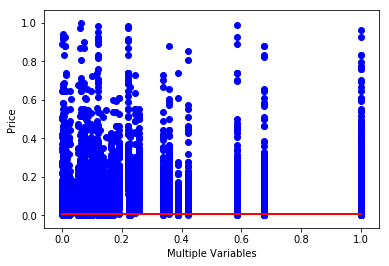

In [53]:
#Multiple linear regression for bedrooms, bathrooms, year built, price per sqft, population, violent crime rate
regr = linear_model.LinearRegression()
train_x = train[['Bedrooms','Bathrooms','Year Built','Price per Sqft','Population','Violent Crime Rate']]
train_y = train[['Price']]
regr.fit (train_x, train_y)

# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ', regr.intercept_)

#Fit line over data
plt.scatter(train.Population, train_y,  color='blue')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.xlabel("Multiple Variables")
plt.ylabel("Price")

#Evaluation
test_x = np.asanyarray(test[['Bedrooms','Bathrooms','Year Built','Price per Sqft','Population','Violent Crime Rate']])
test_y = np.asanyarray(test[['Price']])
test_y_ = regr.predict(test_x)

print("Mean absolute error: %.4f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.4f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.4f" % r2_score(test_y , test_y_) )

#Good R-squared value (0.5981)
#MSE is 0.0032

Coefficients:  [[ 0.30989374 -0.04262488  3.54995429  0.02492954 -0.03311267]]
Intercept:  [0.00597541]
Mean absolute error: 0.0320
Residual sum of squares (MSE): 0.0037
R2-score: 0.6216


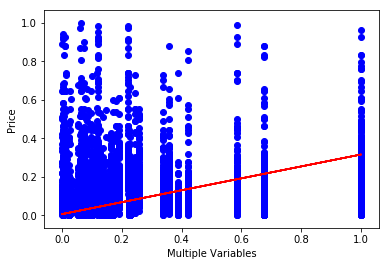

In [54]:
#Multiple linear regression for bathrooms, year built, price per sqft, population, violent crime rate (took out bedrooms)
regr = linear_model.LinearRegression()
train_x = train[['Bathrooms','Year Built','Price per Sqft','Population','Violent Crime Rate']]
train_y = train[['Price']]
regr.fit (train_x, train_y)

# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ', regr.intercept_)

#Fit line over data
plt.scatter(train.Population, train_y,  color='blue')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.xlabel("Multiple Variables")
plt.ylabel("Price")

#Evaluation
test_x = np.asanyarray(test[['Bathrooms','Year Built','Price per Sqft','Population','Violent Crime Rate']])
test_y = np.asanyarray(test[['Price']])
test_y_ = regr.predict(test_x)

print("Mean absolute error: %.4f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.4f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.4f" % r2_score(test_y , test_y_) )

In [55]:
'''
Taking out number of bedrooms yields a slightly better fit for the regression line. For this model compared to the previous
model, the mean absolute error increased slightly and the R squared  decreased slightly (0.5980).
'''

'\nTaking out number of bedrooms yields a slightly better fit for the regression line. For this model compared to the previous\nmodel, the mean absolute error increased slightly and the R squared  decreased slightly (0.5980).\n'

#### Log Transformation

In [56]:
# Try taking log of price and log of population
logdf = Scaleddf

logdf['LogPrice'] = np.log(logdf['Price'])

logdf['LogPopulation'] = np.log(logdf['Population'])

logdf['LogBathrooms'] = np.log(logdf['Bathrooms'])

logdf['LogSqrFt'] = np.log(logdf['Sqr Ft'])

logdf['LogLot_Size'] = np.log(logdf['Lot Size(sqft)'])

logdf.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log


,Price,Sqr Ft,Bedrooms,Bathrooms,Year Built,Days On Trulia,Lot Size(sqft),Price per Sqft,Population,Violent Crime Rate,...,State_TN,State_TX,State_VA,State_WA,State_WI,LogPrice,LogPopulation,LogBathrooms,LogSqrFt,LogLot_Size
0,0.165792,0.003848,0.428571,0.517241,1.000000,0.606742,0.000566,0.013686,0.420407,0.338491,...,0.0,0.0,0.0,0.0,0.0,-1.797024,-0.866532,-0.659246,-5.560077,-7.476357
1,0.055577,0.002832,0.285714,0.448276,0.917160,0.696629,0.000387,0.006240,0.420407,0.338491,...,0.0,0.0,0.0,0.0,0.0,-2.889983,-0.866532,-0.802346,-5.866703,-7.856246
2,0.194333,0.002727,0.428571,0.172414,0.662722,0.005618,0.001062,0.022637,0.420407,0.338491,...,0.0,0.0,0.0,0.0,0.0,-1.638184,-0.866532,-1.757858,-5.904473,-6.847198
3,0.090798,0.002238,0.142857,0.241379,0.739645,1.000000,0.006667,0.012894,0.420407,0.338491,...,0.0,0.0,0.0,0.0,0.0,-2.399120,-0.866532,-1.421386,-6.102145,-5.010590
4,0.035051,0.001933,0.428571,0.172414,0.786982,0.151685,0.000657,0.005772,0.420407,0.338491,...,0.0,0.0,0.0,0.0,0.0,-3.350946,-0.866532,-1.757858,-6.248591,-7.327177


In [57]:
# Check data types
logdf.dtypes

Price                      float64
Sqr Ft                     float64
Bedrooms                   float64
Bathrooms                  float64
Year Built                 float64
Days On Trulia             float64
Lot Size(sqft)             float64
Price per Sqft             float64
Population                 float64
Violent Crime Rate         float64
Property Crime Rate        float64
City_Albuquerque           float64
City_Anaheim               float64
City_Anchorage             float64
City_Apple Valley          float64
City_Arlington             float64
City_Atlantic Beach        float64
City_Aurora                float64
City_Austin                float64
City_Aventura              float64
City_Bainbridge Island     float64
City_Baker                 float64
City_Bakersfield           float64
City_Baltimore             float64
City_Baton Rouge           float64
City_Bay Harbor Islands    float64
City_Bay Village           float64
City_Bayside               float64
City_Beachwood      

In [58]:
# Get rid of Nan and infinite values
logdf =logdf[~logdf.isin([np.nan, np.inf, -np.inf]).any(1)]

In [59]:

#feature scale all numerical data using min and max
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

logdfnum = logdf.select_dtypes(exclude=['object'])

columnnames= list(logdfnum.columns)     #save column names as a list

#Use MinMax scaler to normalize the data and feature scale between 0 and 1
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
logscaleddf = scaler.fit_transform(logdfnum)
logscaleddf = pd.DataFrame(logscaleddf, columns=columnnames)
print(logscaleddf)


          Price    Sqr Ft  Bedrooms  Bathrooms  Year Built  Days On Trulia  \
0      0.165753  0.003738  0.428571   0.500000    1.000000        0.606742   
1      0.055533  0.002722  0.285714   0.428571    0.917160        0.696629   
2      0.194295  0.002617  0.428571   0.142857    0.662722        0.005618   
3      0.090756  0.002128  0.142857   0.214286    0.739645        1.000000   
4      0.035006  0.001823  0.428571   0.142857    0.786982        0.151685   
5      0.044267  0.002595  0.428571   0.142857    0.704142        0.353933   
6      0.047231  0.002917  0.571429   0.428571    0.928994        1.000000   
7      0.051658  0.001785  0.428571   0.142857    0.763314        0.073034   
8      0.029450  0.001296  0.285714   0.142857    0.710059        0.370787   
9      0.049435  0.001353  0.285714   0.071429    0.579882        0.005618   
10     0.085016  0.002604  0.428571   0.142857    0.905325        0.000000   
11     0.034071  0.001000  0.142857   0.142857    0.881657      

In [60]:
#Display column headings
logscaleddf.columns

Index(['Price', 'Sqr Ft', 'Bedrooms', 'Bathrooms', 'Year Built',
       'Days On Trulia', 'Lot Size(sqft)', 'Price per Sqft', 'Population',
       'Violent Crime Rate',
       ...
       'State_TN', 'State_TX', 'State_VA', 'State_WA', 'State_WI', 'LogPrice',
       'LogPopulation', 'LogBathrooms', 'LogSqrFt', 'LogLot_Size'],
      dtype='object', length=386)

In [61]:
#Find location (column number) of first city
logscaleddf.columns.get_loc('City_Albuquerque')

11

In [62]:
#Find location of first state
logscaleddf.columns.get_loc('State_AL')

350

In [1]:
# Regression Model for year built, City, LogBathrooms, LogSqrFt, and Log_LotSize (significant variables obtained from
# step wise regression in R)

In [91]:
# get all predictor variables needed for multiple regression with log transformed variables
city = logscaleddf.iloc[:, 11:350] 
year = logscaleddf.iloc[:, 4] 
logvars = logscaleddf.iloc[:, 383:386]

# Dataframe for predictor variables
X = pd.concat([year, city, logvars], axis=1)
X.head()

,Year Built,City_Albuquerque,City_Anaheim,City_Anchorage,City_Apple Valley,City_Arlington,City_Atlantic Beach,City_Aurora,City_Austin,City_Aventura,...,City_Wichita,City_Windsor Heights,City_Winter Park,City_Wolfforth,City_Woodbury,City_Worthington,City_Yukon,LogBathrooms,LogSqrFt,LogLot_Size
0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.804221,0.389668,0.418937
1,0.917160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.761724,0.356010,0.389412
2,0.662722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.477962,0.351864,0.467836
3,0.739645,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.577885,0.330165,0.610577
4,0.786982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.477962,0.314090,0.430532


In [92]:
#define response variable dataframe
Y = logscaleddf.iloc[:, 381]
Y.head()

0    0.819943
1    0.710432
2    0.835858
3    0.759615
4    0.664244
Name: LogPrice, dtype: float64

In [93]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=101)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(17337, 343)
(4335, 343)
(17337,)
(4335,)


In [94]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [95]:
# print the intercept
print(model.intercept_)
# The coefficients
print ('Coefficients: ', model.coef_)

0.5891898902239286
Coefficients:  [ 2.65210048e-02 -8.92271708e-02 -8.40368679e-03 -6.92045159e-02
 -7.84221360e-02 -7.65833947e-02 -4.47949958e-03 -3.31804490e-02
 -1.89956723e-02 -3.65441293e-02  4.26287770e-03 -8.32408549e+09
 -6.64897322e-02 -9.23323195e-02 -1.35917712e-01 -5.11416144e-02
 -4.39216046e-02 -4.76974674e-02 -1.37527408e-01 -1.28849905e-01
  4.06368506e-02 -3.78661929e-02 -4.17911651e-02 -7.05212921e-02
 -4.31715115e-02 -5.43376036e+10  1.24198002e-01 -2.86322759e-02
 -1.66038879e-02 -7.73569637e-02 -3.73384272e-02 -4.28928353e-02
 -1.59737760e-02 -3.92556465e-02 -4.20324931e-02  3.31020241e+10
 -2.52721212e-02 -8.53712442e-02 -7.26325065e-02 -9.91876262e-02
 -9.64607841e-02  4.11306332e-03  3.14522104e-02 -8.34061759e-02
  4.78914450e-02  1.77499941e-02 -1.28062940e-02 -5.96570799e-02
 -5.87908453e-02 -5.09887478e-02 -7.51021243e-02 -3.60261343e-02
 -8.24185356e-02 -1.51573990e-02 -9.25739731e-02 -1.31119593e-01
 -1.05235708e-01 -6.30983198e-02 -8.09509068e-02 -1.2997

In [96]:
# predictions from the training model using the testing set
predictions = model.predict(X_test)
predictions

array([0.70944115, 0.67195674, 0.68256967, ..., 0.71244601, 0.7299473 ,
       0.72687803])

In [98]:
# Print the OLS output with coefficients for each variable

import statsmodels.api as sm
X_train_Sm= sm.add_constant(X_train)
X_train_Sm= sm.add_constant(X_train)
ls=sm.OLS(y_train,X_train_Sm).fit()
print(ls.summary())

/opt/conda/envs/Python36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:               LogPrice   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     56.57
Date:                Fri, 22 Jan 2021   Prob (F-statistic):               0.00
Time:                        01:50:31   Log-Likelihood:                 21185.
No. Observations:               17337   AIC:                        -4.170e+04
Df Residuals:                   17001   BIC:                        -3.909e+04
Df Model:                         335                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [2]:
# The adjusted R-squared is 0.518. These variables explain about 52% of the variation in log(Price).
#This is a smaller R-squared than the model in R.

In [99]:
# Evaluate accuracy on test set

print("Mean absolute error: %.4f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.4f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.4f" % r2_score(test_y , test_y_) )

Mean absolute error: 0.0320
Residual sum of squares (MSE): 0.0037
R2-score: 0.6216


In [154]:
'''
The R-squared for using log variables is 0.6216, which is a bit higher. Year Built, City,
LogBathrooms, LogLot_Size, and LogSqrFt explain about 62% of the variation in LogPrice.
The MSE is low, which is good.

This model produced a better R-squared in my test set than my final model in R.
'''

'\nThe R-squared for using log variables is 0.6216, which is a bit higher. Year Built, City,\nLogBathrooms, LogLot_Size, and LogSqrFt explain about 62% of the variation in LogPrice.\nThe MSE is low, which is good.\n\nThis model produced a better R-squared than my final model in R.\n'

In [105]:
##### cross validation #####      instead of training test split 80/20

#method that uses resampling.
#k-fold : k=10 : chooses 10 groups(folds) randomly and performs the model on training and test sets 
#so each group has a chance to be held as the test set

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn import svm

In [110]:
#k-fold cross validation for model with 'LogPrice' vs 'LogBathrooms','Year Built','LogSqrFt','LogLot_Size','City'

lm = LinearRegression()
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=10)   

print("R Squared scores",scores)
print("R Squared mean",np.mean(scores))

#Cross fold prediction
pred=cross_val_predict(lm, X_train, y_train, cv=10)

print("Predictions",pred)

#worse than from 80/20 training and test sets

R Squared scores [-1.81316459e+24 -8.92799607e+23 -2.64874281e+23 -4.47670917e+24
 -1.00004514e+22 -1.23604204e+26 -1.71802917e+25 -3.55980562e+24
 -9.74489640e+24 -4.79209878e+24]
R Squared mean -1.663388443960267e+25
Predictions [0.71381742 0.68521831 0.69927206 ... 0.6783373  0.67607983 0.61413635]


In [ ]:
'''
Using cross validation on the same model as the previous model instead of using an 80/20 split gives a lower R-squared 
mean value of a very high negative number, which is not good. Therefore, we conclude that using the 80/20 split is better 
than k-fold cross validation.
'''

### Model with only data for California

In [127]:
#Check data from feature scaled data (logscaleddf)
logscaleddf.head()

,Price,Sqr Ft,Bedrooms,Bathrooms,Year Built,Days On Trulia,Lot Size(sqft),Price per Sqft,Population,Violent Crime Rate,...,State_TN,State_TX,State_VA,State_WA,State_WI,LogPrice,LogPopulation,LogBathrooms,LogSqrFt,LogLot_Size
0,0.165753,0.003738,0.428571,0.500000,1.000000,0.606742,0.000564,0.013685,0.420393,0.338491,...,0.0,0.0,0.0,0.0,0.0,0.819943,0.918567,0.804221,0.389668,0.418937
1,0.055533,0.002722,0.285714,0.428571,0.917160,0.696629,0.000385,0.006239,0.420393,0.338491,...,0.0,0.0,0.0,0.0,0.0,0.710432,0.918567,0.761724,0.356010,0.389412
2,0.194295,0.002617,0.428571,0.142857,0.662722,0.005618,0.001060,0.022636,0.420393,0.338491,...,0.0,0.0,0.0,0.0,0.0,0.835858,0.918567,0.477962,0.351864,0.467836
3,0.090756,0.002128,0.142857,0.214286,0.739645,1.000000,0.006664,0.012893,0.420393,0.338491,...,0.0,0.0,0.0,0.0,0.0,0.759615,0.918567,0.577885,0.330165,0.610577
4,0.035006,0.001823,0.428571,0.142857,0.786982,0.151685,0.000655,0.005771,0.420393,0.338491,...,0.0,0.0,0.0,0.0,0.0,0.664244,0.918567,0.477962,0.314090,0.430532


In [130]:
#define data attributes to use
scale = logscaleddf.iloc[:, 0:11]
log = logscaleddf.iloc[:, 381: 386]
#Concat both dataframes together
logscale = pd.concat([scale, log], axis=1, sort=False)
logscale.head()

,Price,Sqr Ft,Bedrooms,Bathrooms,Year Built,Days On Trulia,Lot Size(sqft),Price per Sqft,Population,Violent Crime Rate,Property Crime Rate,LogPrice,LogPopulation,LogBathrooms,LogSqrFt,LogLot_Size
0,0.165753,0.003738,0.428571,0.500000,1.000000,0.606742,0.000564,0.013685,0.420393,0.338491,0.415143,0.819943,0.918567,0.804221,0.389668,0.418937
1,0.055533,0.002722,0.285714,0.428571,0.917160,0.696629,0.000385,0.006239,0.420393,0.338491,0.415143,0.710432,0.918567,0.761724,0.356010,0.389412
2,0.194295,0.002617,0.428571,0.142857,0.662722,0.005618,0.001060,0.022636,0.420393,0.338491,0.415143,0.835858,0.918567,0.477962,0.351864,0.467836
3,0.090756,0.002128,0.142857,0.214286,0.739645,1.000000,0.006664,0.012893,0.420393,0.338491,0.415143,0.759615,0.918567,0.577885,0.330165,0.610577
4,0.035006,0.001823,0.428571,0.142857,0.786982,0.151685,0.000655,0.005771,0.420393,0.338491,0.415143,0.664244,0.918567,0.477962,0.314090,0.430532


In [131]:
# Specify data for city/state
citystatedata = Zscoredf.iloc[:, 11:13]
citystatedata.head()

,City,State
0,Phoenix,AZ
1,Phoenix,AZ
2,Phoenix,AZ
3,Phoenix,AZ
4,Phoenix,AZ


In [132]:
# Concat the log scale data with the city/state dataframe
newdf = pd.concat([logscale, citystatedata], axis=1)
newdf.head()

,Price,Sqr Ft,Bedrooms,Bathrooms,Year Built,Days On Trulia,Lot Size(sqft),Price per Sqft,Population,Violent Crime Rate,Property Crime Rate,LogPrice,LogPopulation,LogBathrooms,LogSqrFt,LogLot_Size,City,State
0,0.165753,0.003738,0.428571,0.500000,1.000000,0.606742,0.000564,0.013685,0.420393,0.338491,0.415143,0.819943,0.918567,0.804221,0.389668,0.418937,Phoenix,AZ
1,0.055533,0.002722,0.285714,0.428571,0.917160,0.696629,0.000385,0.006239,0.420393,0.338491,0.415143,0.710432,0.918567,0.761724,0.356010,0.389412,Phoenix,AZ
2,0.194295,0.002617,0.428571,0.142857,0.662722,0.005618,0.001060,0.022636,0.420393,0.338491,0.415143,0.835858,0.918567,0.477962,0.351864,0.467836,Phoenix,AZ
3,0.090756,0.002128,0.142857,0.214286,0.739645,1.000000,0.006664,0.012893,0.420393,0.338491,0.415143,0.759615,0.918567,0.577885,0.330165,0.610577,Phoenix,AZ
4,0.035006,0.001823,0.428571,0.142857,0.786982,0.151685,0.000655,0.005771,0.420393,0.338491,0.415143,0.664244,0.918567,0.477962,0.314090,0.430532,Phoenix,AZ


In [133]:
# create data frame for only the data for California (CA has highest housing prices)
CAdf = newdf[newdf.State == 'CA']
CAdf.head()

,Price,Sqr Ft,Bedrooms,Bathrooms,Year Built,Days On Trulia,Lot Size(sqft),Price per Sqft,Population,Violent Crime Rate,Property Crime Rate,LogPrice,LogPopulation,LogBathrooms,LogSqrFt,LogLot_Size,City,State
4818,0.051491,0.001976,0.285714,0.142857,0.828402,0.078652,0.000716,0.007856,0.096406,0.220385,0.525532,0.702865,0.780195,0.477962,0.322451,0.437449,Bakersfield,CA
4819,0.047222,0.001974,0.428571,0.214286,0.917160,0.376404,0.000310,0.007214,0.096406,0.220385,0.525532,0.694202,0.780195,0.577885,0.322333,0.372711,Bakersfield,CA
4820,0.051584,0.001922,0.428571,0.142857,0.881657,0.370787,0.000435,0.008078,0.096406,0.220385,0.525532,0.703045,0.780195,0.477962,0.319593,0.398862,Bakersfield,CA
4821,0.027598,0.005566,0.285714,0.142857,0.739645,1.000000,0.000997,0.001546,0.096406,0.220385,0.525532,0.640453,0.780195,0.477962,0.432313,0.463124,Bakersfield,CA
4822,0.033154,0.001458,0.285714,0.142857,0.627219,0.853933,0.000747,0.006741,0.096406,0.220385,0.525532,0.658804,0.780195,0.477962,0.291107,0.440760,Bakersfield,CA


In [134]:
#Which cities are most prevalet in the data?
city_counts = CAdf['City'].value_counts()
print(city_counts)
#Highest number of houses from Texas

Los Angeles        434
San Diego          326
Bakersfield        175
San Jose           157
San Francisco      148
Riverside          114
Irvine             110
Oakland             86
Stockton            71
Long Beach          67
Modesto             66
Chula Vista         60
Anaheim             56
Fremont             47
Santa Ana           35
Coronado            17
West Hollywood      17
Jurupa Valley       12
Fountain Valley     10
Carson               8
Culver City          7
Beverly Hills        7
Del Mar              6
Torrance             4
Burbank              3
Piedmont             2
San Fernando         2
Campbell             2
Signal Hill          1
Santee               1
Berkeley             1
Eastvale             1
Ceres                1
Name: City, dtype: int64


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 <a list of 33 Text xticklabel objects>)

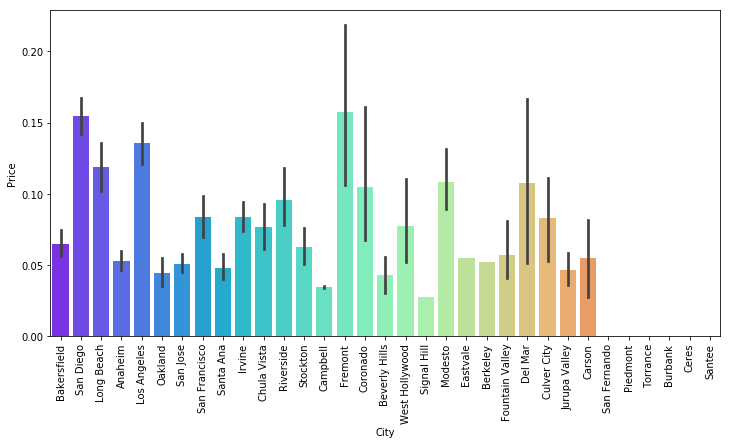

In [141]:
#Bar plot of Price vs City
plt.figure(figsize=(12,6))
sb.barplot(x='City', y='Price', data=CAdf, palette='rainbow')
                                                                        
plt.xticks(rotation = 90)

In [142]:
# Piedmont, San Diego, and Los Angeles have highest housing prices

In [146]:
# Get rid of Nan and infinite values
CAdf = CAdf[~CAdf.isin([np.nan, np.inf, -np.inf]).any(1)]

In [147]:
#Split data into training set(80%) and test set(20%) 
#Creating training and testing set by choosing random observations
rand = np.random.rand(len(CAdf)) < 0.8
train = CAdf[rand]
test = CAdf[~rand]

Coefficients:  [[ 0.15932616 -0.06497918  0.01237195 -0.0607037  -0.09612862]]
Intercept:  [0.73694104]
Mean absolute error: 0.0639
Residual sum of squares (MSE): 0.0066
R2-score: 0.1857


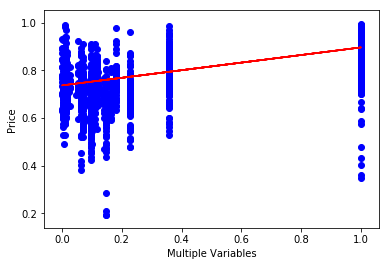

In [150]:
# Regression with logged variables
#Multiple linear regression for LogBathrooms','Year Built', 'LogLot_Size', 'LogSqrFt'
regr = linear_model.LinearRegression()
train_x = train[['LogBathrooms','Year Built', 'LogLot_Size', 'LogSqrFt', 'Violent Crime Rate']]
train_y = train[['LogPrice']]
regr.fit (train_x, train_y)

# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ', regr.intercept_)

#Fit line over data
plt.scatter(train.Population, train_y,  color='blue')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.xlabel("Multiple Variables")
plt.ylabel("Price")

#Evaluation
test_x = np.asanyarray(test[['LogBathrooms','Year Built', 'LogLot_Size', 'LogSqrFt', 'Violent Crime Rate']])
test_y = np.asanyarray(test[['LogPrice']])
test_y_ = regr.predict(test_x)

print("Mean absolute error: %.4f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.4f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.4f" % r2_score(test_y , test_y_) )

In [ ]:
'''
Using just data from California, the multiple linear regression for price vs bathrooms, year built, lot_size, SqrFt, 
and violent crime rate gives an R-squared of about 0.186 and a MSE of 0.007. These variables explain about 19% of the 
variation in log housing prices for California.

This shows just how important location is in predicting the price of real estate. Only having one State included in the data
for linear regression results in a worse model than if lots of different states were included.
'''

In [ ]:
ftscdf = pd.DataFrame(newdf)  #ftsc stands for feature scaled data with categorical data (not 1-hotted) --> use this data in R

# Export ftscdf as a csv file to project assets

#@hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='e5b5564f-3061-4776-af66-2ba2d1874948', project_access_token='p-afce1f171120edb3c4d766e0d3b5a708f5fbf7d5')
pc = project.project_context

# save in your object storage as a csv file
project.save_data("ftscdf.csv", ftscdf.to_csv(index=False),overwrite = True)


In [151]:
'''
Final Model in R with logged variables: 
LogPrice vs. LogBathrooms, LogBedrooms, Year_Built, LogSize, LogLot_Size, City
Adjusted R-squared:  0.5698 (slightly better than model in Python)
'''

'\nFinal Model in R with logged variables: \nLogPrice vs. LogBathrooms, LogBedrooms, Year_Built, LogSize, LogLot_Size, City\nAdjusted R-squared:  0.5713 \n'

In [ ]:
# Tableau -visualizations and dashboards (maps)